In [37]:
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from EFBP import minimize_squared_error, make_uniform_strategies, EFBPSim

rng = np.random.default_rng(444)

In [27]:
class EvolvingEFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        m_min=2,
        m_max=20,
        s_min=2,
        s_max=20,
        tol_rate = 0.5,
        tol_window=10,
        switch_prob=0.2,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="uniform",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # file to write attendance history as it is generated
        writefile=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        # shape is (agents, strategies,memory)
        strats = {
            memory: strategy_func(rng, strategies*agents, memory)
        }

        agent_indices = {
            memory: np.array([[i*strategies, (i+1) * strategies] for i in range(agents)])
        }

        if start is None:
            start = rng.choice(agents, size=(m_max*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)
            
        agent_went = {
            memory: np.zeros((agents, len(hist)))
        }
            
        # index of week
        # we need some starting history to begin making selections
        t = m_max * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = {
            memory: np.zeros((agents, len(hist)), dtype=int)
        }

        # set up the predictions for initial history
        windows = np.vstack([
            hist[t-2*memory+i: t-memory + i]
            for i in range(memory)
        ])

        pred_history = {
            memory: np.zeros((agents * strategies, len(hist)))
        }
            
        pred_history[memory][:, memory:2*memory] = strats[memory].dot(windows)

        best_preds = {
            memory:np.zeros((agents, len(hist)))
        }
        
        # store the memory and strategies for each agent
        # at each timestep
        params = np.zeros((m_max+1, s_max+1, len(hist)))
        
        switch_counts = np.zeros(len(hist), dtype=int)
 
        while t < len(hist):
            
            for m in strats.keys():
                strat_counts = Counter()
                
                window = hist[t-m:t]
                
                try:
                    pred_history[m][:,t] = strats[m].dot(window)
                    
                except Exception as E:
                    print(t)
                    print(m)
                    print(t-m)
                    print(window)
                    print(pred_history[m])
                    print(strats[m])
                    assert False

                for agent, [i,j] in enumerate(agent_indices[m]):
                    strat_counts.update([j - i])
                    assert j-i < s_max
                    
                    strat = strats[m][i:j]

                    predictions = pred_history[m][i:j,t-m:t]
                    observations = hist[t-m:t]
                    
                    mask = ~np.isnan(predictions)
                    
                    # sanity check that all rows have same values
                    try:
                        assert (mask.any(axis=0) == mask.all(axis=0)).all()
                    except Exception as e:
                        print(i)
                        print(j)
                        print(predictions)
                        print(m)
                        print(mask)
                        raise e
                    
                    if (mask==False).all():
                        best_strat = 0
                    else:
                        # find first week with valid predictions
                        start_col = np.where(mask)[1][0]
                        best_strat = best_strat_func(rng, predictions[:, start_col:], observations[start_col:], threshold, j-i)
                        
                    best_strats[m][agent, t] = best_strat
                    best_preds[m][agent, t] = pred_history[m][i + best_strat, t]

                hist[t] += (best_preds[m] [:,t] < threshold).sum()
                
                for s, cnt in strat_counts.items():
                    params[m, s, t] = cnt
                
                
            # go back through and evaluate if the agent needs
            # to change parameters once we know the last attendance value
            ms = list(strats.keys())
            for m in ms:
                if t < 2 * m + tol_window :
                    continue
                    
                optimal_choices = hist[t-tol_window:t] < threshold
                
                # iterate through agents in reverse order
                # so enumeration doesn't get messed up
                # when earlier agents are deleted.
                n_agents = len(agent_indices[m])
                
                for agent in range(-1, -n_agents, -1):
                    
                    # flip index back to the right direction
                    agent = n_agents + agent
                    
                    (i,j) = agent_indices[m][agent]
                    
                    # first check that the agent has been in this regime for long enough.
                    if np.isnan(best_preds[m][agent, t-tol_window]):
                        continue

                    attendance = best_preds[m][agent, t-tol_window:t] < threshold
                    
                    correct_rate =(attendance == optimal_choices).mean()
                    
                    if correct_rate < tol_rate and rng.random() < switch_prob:
                        switch_counts[t] += 1
                        
                        new_m = rng.choice(m_max - m_min) + m_min
                        new_s = rng.choice(s_max - s_min) + s_min
                        
                        assert strats[m].shape[0] == pred_history[m].shape[0]                        

                        # delete old agent
                        strats[m] = np.vstack([
                            strats[m][:i],
                            strats[m][j:]
                        ])

                        pred_history[m] = np.vstack([
                            pred_history[m][:i],
                            pred_history[m][j:]
                        ])

                        # reindex later agents
                        if agent == len(agent_indices[m]) - 1:
                            agent_indices[m] = agent_indices[m][:-1]
                        else:
                            agent_indices[m] = np.vstack([
                                agent_indices[m][:agent],
                                agent_indices[m][agent+1:] - (j - i)
                            ])
                        try:
                            assert agent_indices[m].min() == 0
                        except:
                            print(agent_indices)
                            print(agent_indices[m].min())
                            assert False

                        best_preds[m] = np.vstack([
                            best_preds[m][:agent, :],
                            best_preds[m][agent+1:,:]
                        ])
                        
                        best_strats[m] = np.vstack([
                            best_strats[m][:agent, :],
                            best_strats[m][agent+1:,:]
                        ])

                        # add new strategies where appropriate
                        strats[new_m] = np.vstack([
                            strats.get(new_m, np.zeros((0, new_m))),
                            strategy_func(rng, new_s, new_m)
                        ])
                        
                        pred_history[new_m] = np.vstack([
                            pred_history.get(new_m, np.zeros((0, len(hist)))),
                            np.full((new_s,len(hist)), np.nan)
                        ])

                        if new_m in agent_indices:
                            new_i = agent_indices[new_m].max()
                            new_j = new_i + new_s
                            agent_indices[new_m] = np.vstack([
                                agent_indices[new_m],
                                np.array([new_i, new_j])
                            ])
                        else:
                            new_i = 0
                            new_j = new_s
                            agent_indices[new_m] = np.array([[0, new_s]])

                        # best preds get reset when agent changes strategy
                        new_best_preds = np.full((1,len(hist)), np.nan)

                        if new_m in best_preds:
                            best_preds[new_m] = np.vstack([
                                best_preds[new_m],
                                new_best_preds
                            ])
                            best_strats[new_m] = np.vstack([
                                best_strats[new_m],
                                new_best_preds
                            ])
 
                        else:
                            best_preds[new_m] = new_best_preds
                            best_strats[new_m] = new_best_preds
                            

            if writefile:
                with open(writefile, "a") as f:
                    f.write(str(hist[t]) + ",")

            t += 1
    
        self.t = t
        self.hist = hist[2*m_max:t]
        self.best_strats = best_strats
        self.pred_history = pred_history
        self.strats = strats
        self.params = params[:, :, 2*m_max:t]
        self.switch_counts = switch_counts[2*m_max:t]

        
    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]

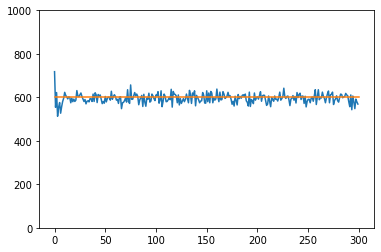

In [31]:
agents = 1000
strategies = 5
memory = 8
threshold=0.6 * agents
n_iter = 300
seed = 1


sim = EvolvingEFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    s_min=2,
    s_max=50,
    m_min=2,
    m_max=50,
    distribution="uniform",
    seed=seed)


plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])
_ = plt.ylim([0,agents])

<AxesSubplot:>

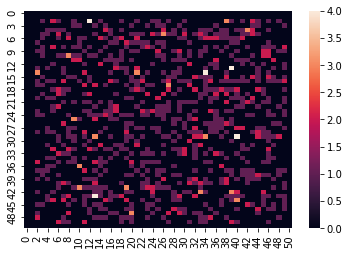

In [32]:
sns.heatmap(sim.params[:, :, 299])

<AxesSubplot:>

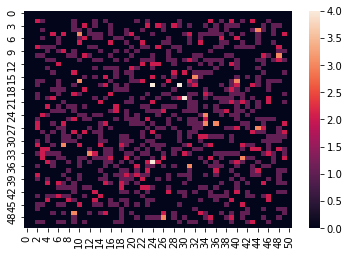

In [33]:
sns.heatmap(sim.params[:, :, 200])

<AxesSubplot:>

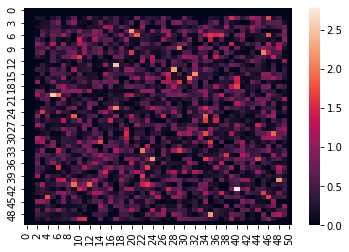

In [34]:
sns.heatmap(sim.params[:, :, 200:300].mean(axis=2))

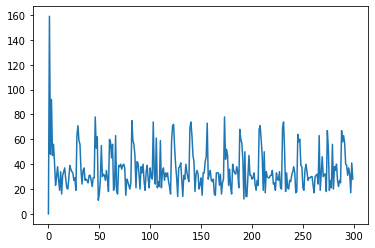

In [38]:
plt.plot(sim.switch_counts)

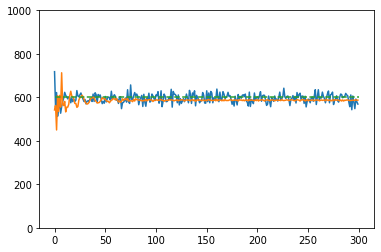

In [41]:
agents = 1000
strategies = 5
memory = 8
threshold=0.6 * agents
n_iter = 300
seed = 1

old_sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)


plt.plot(sim.hist)
plt.plot(old_sim.hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

In [42]:
old_sim.hist[-20:]

array([586, 584, 588, 583, 588, 583, 587, 586, 588, 588, 586, 585, 586,
       586, 587, 587, 586, 589, 587, 587])

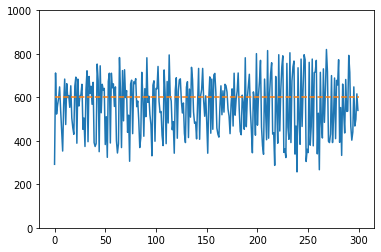

In [48]:
agents = 1000
strategies = 30
memory = 10
threshold=0.6 * agents
n_iter = 300
seed = 1

old_sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)



plt.plot(old_sim.hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

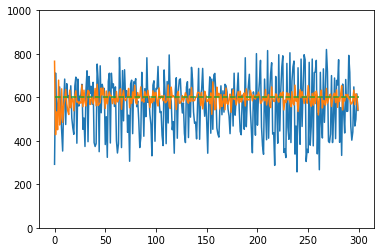

In [60]:
agents = 1000
s = 30
m = 10
threshold=0.6 * agents
n_iter = 300
seed = 1


sim = EvolvingEFBPSim(
    agents=agents,
    strategies=s,
    memory=m,
    threshold=threshold,
    n_iter=n_iter,
    s_min=s//2,
    s_max=s + s//2,
    m_min=m//2,
    m_max=m+m//2,
    distribution="uniform",
    seed=seed)


plt.plot(old_sim.hist)
plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

<AxesSubplot:>

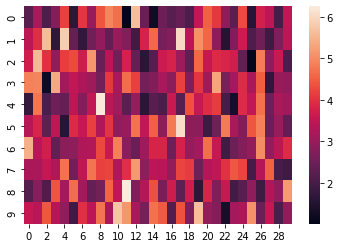

In [61]:
sns.heatmap(sim.params[m//2:m+m//2,s//2:s + s//2, 200:300].mean(axis=2))

<AxesSubplot:>

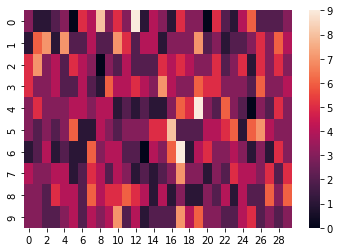

In [62]:
sns.heatmap(sim.params[m//2:m+m//2,s//2:s + s//2, -1])

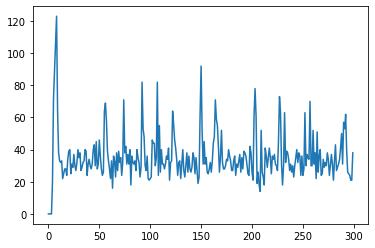

In [63]:
plt.plot(sim.switch_counts)

In [66]:
agents = 1000
s = 30
m = 10
threshold=0.6 * agents
n_iter = 300
seed = 1

sims = dict()
tol_rates = [0.2, 0.4, 0.6, 0.8]

for tol_rate in tol_rates:
    sims[tol_rate] = EvolvingEFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        threshold=threshold,
        n_iter=n_iter,
        s_min=s//2,
        s_max=s + s//2,
        m_min=m//2,
        m_max=m+m//2,
        tol_rate=tol_rate,
        distribution="uniform",
        seed=seed)

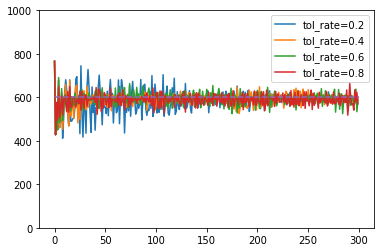

In [67]:
for tol_rate in tol_rates:
    plt.plot(sims[tol_rate].hist)
    
plt.legend([f"tol_rate={tol_rate}" for tol_rate in tol_rates])
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

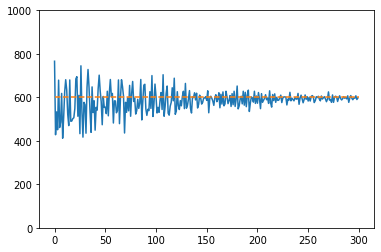

In [70]:
plt.plot(sims[0.2].hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

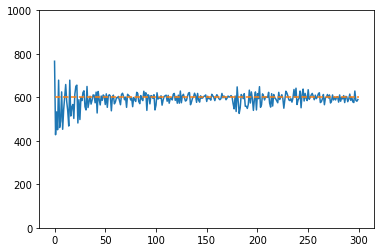

In [71]:
plt.plot(sims[0.4].hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

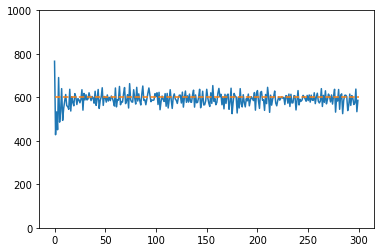

In [72]:
plt.plot(sims[0.6].hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

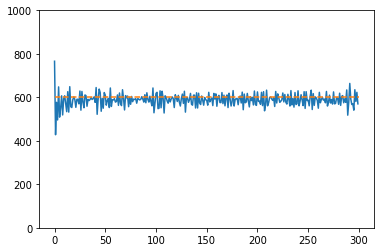

In [73]:
plt.plot(sims[0.8].hist)
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

It seems like when *tol_rate* is very low, attendance takes longer to stabilize, but once it gets higher it stops making such a big difference.

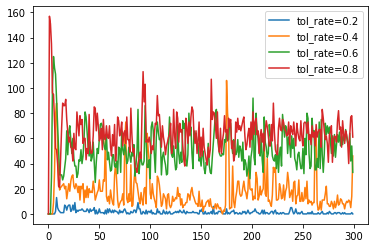

In [76]:
for tol_rate in tol_rates:
    plt.plot(sims[tol_rate].switch_counts)
    
plt.legend([f"tol_rate={tol_rate}" for tol_rate in tol_rates])

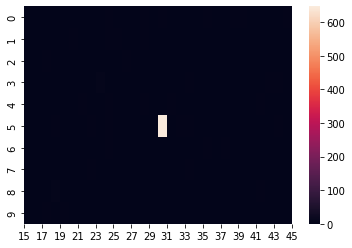

In [95]:
sns.heatmap(sims[0.2].params[m//2:m+m//2,s//2:s + s//2, 200:300].mean(axis=2))

s_ticks = np.arange(0, s+1, 2)
s_tick_labels = np.arange(s//2, s + s//2+1, 2) 

m_ticks = np.arange(0, m+1)
m_tick_labels = np.arange(m//2, m + m//2+1) 
_ = plt.xticks(s_ticks, s_tick_labels)

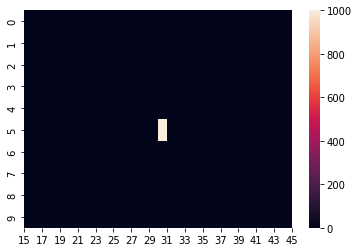

In [96]:
sns.heatmap(sims[0.2].params[m//2:m+m//2,s//2:s + s//2, 0])

s_ticks = np.arange(0, s+1, 2)
s_tick_labels = np.arange(s//2, s + s//2+1, 2) 

m_ticks = np.arange(0, m+1)
m_tick_labels = np.arange(m//2, m + m//2+1) 
_ = plt.xticks(s_ticks, s_tick_labels)

In [97]:
sims[0.2].params[m//2:m+m//2,s//2:s + s//2, -1]

array([[  2.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   2.,   3.,   1.,
          2.,   1.,   3.,   0.,   3.,   1.,   0.,   1.,   0.,   3.,   2.,
          1.,   4.,   5.,   2.,   1.,   1.,   0.,   3.],
       [  2.,   1.,   1.,   2.,   0.,   3.,   0.,   2.,   2.,   3.,   3.,
          1.,   1.,   3.,   2.,   2.,   0.,   1.,   2.,   0.,   1.,   2.,
          1.,   1.,   2.,   2.,   2.,   2.,   0.,   1.],
       [  0.,   3.,   3.,   1.,   1.,   0.,   2.,   1.,   0.,   1.,   0.,
          3.,   1.,   1.,   2.,   0.,   1.,   0.,   2.,   2.,   1.,   0.,
          2.,   1.,   0.,   0.,   1.,   2.,   0.,   0.],
       [  2.,   0.,   0.,   2.,   1.,   2.,   0.,   1.,   6.,   2.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   1.,   0.,   0.,
          2.,   0.,   0.,   0.,   1.,   3.,   3.,   1.],
       [  1.,   1.,   1.,   0.,   0.,   0.,   4.,   0.,   0.,   3.,   1.,
          1.,   2.,   4.,   0.,   1.,   5.,   0.,   1.,   1.,   1.,   2.,
          1.,   0.,   1.,   1., 

In [100]:
sims[0.2].params[m//2:m+m//2,s//2:s + s//2, 0]

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.],
       [   0.,    0.,    0.,

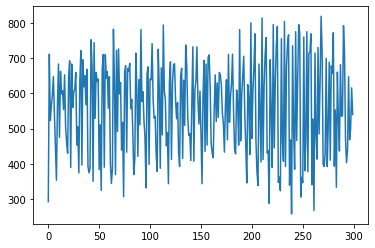

In [99]:
agents = 1000
s = 30
m = 10
threshold=0.6 * agents
n_iter = 300
seed = 1

old_sim = EFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        threshold=threshold,
        n_iter=n_iter,
        distribution="uniform",
        seed=seed)

plt.plot(old_sim.hist)

It seems like with tol_rate of 0.2, the number of agents that stick with the original strategy distribution is close to the threshold.  Does this pattern hold up with other values?

In [101]:
agents = 1000
s = 30
m = 10
n_iter = 300
seed = 1
tol_rate = 0.2

sims = dict()
thresholds = [0.2, 0.4, 0.6, 0.8]

for threshold in thresholds:
    sims[threshold] = EvolvingEFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        threshold=threshold*agents,
        n_iter=n_iter,
        s_min=s//2,
        s_max=s + s//2,
        m_min=m//2,
        m_max=m+m//2,
        tol_rate=tol_rate,
        distribution="uniform",
        seed=seed)

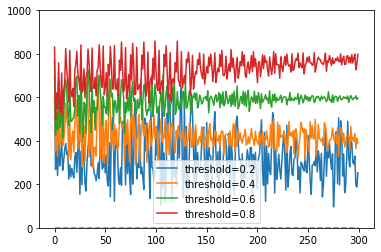

In [102]:
for threshold in thresholds:
    plt.plot(sims[threshold].hist)
    
plt.legend([f"threshold={threshold}" for threshold in thresholds])
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])

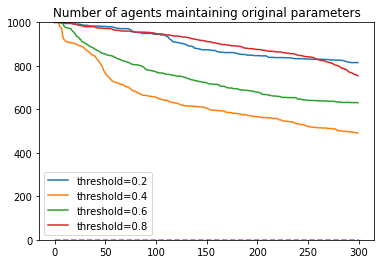

In [105]:
for threshold in thresholds:
    plt.plot(sims[threshold].params[m, s, :])
    
plt.legend([f"threshold={threshold}" for threshold in thresholds])
plt.title("Number of agents maintaining original parameters")
plt.plot([0, n_iter], [threshold, threshold], "--")
_ = plt.ylim([0,agents])